# Logic for Data Processing

In [1]:
!pip install paramiko python-dotenv pandas matplotlib

In [2]:
import paramiko
import os
import json
from dotenv import load_dotenv
from typing import TypedDict, List, Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt



# Load environment variables from the .env file
load_dotenv()

# SSH connection settings from environment variables
SSH_CONFIG = {
    "hostname": os.getenv('SSH_HOSTNAME'),
    "port": int(os.getenv('SSH_PORT', 22)),
    "username": os.getenv('SSH_USERNAME'),
    "password": os.getenv('SSH_PASSWORD'),
}

class Event(TypedDict):
    counter_value: str
    unit: str
    event: str
    event_runtime: int
    pcnt_running: float
    metric_value: float
    metric_unit: str

class SSHConnection:
    """Handles SSH and SFTP connections."""
    def __init__(self, config):
        self.config = config
        self.ssh = None
        self.sftp = None

    def __enter__(self):
        self.ssh = paramiko.SSHClient()
        self.ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        self.ssh.connect(
            hostname=self.config['hostname'],
            port=self.config['port'],
            username=self.config['username'],
            password=self.config['password']
        )
        self.sftp = self.ssh.open_sftp()
        return self.sftp

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.sftp:
            self.sftp.close()
        if self.ssh:
            self.ssh.close()

class JSONLoader:
    """Loads JSON files from a remote server via SFTP."""
    def __init__(self, sftp):
        self.sftp = sftp

    def is_directory(self, path):
        """Check if a path is a directory."""
        try:
            stats = self.sftp.stat(path)
            return stats.st_mode & 0o170000 == 0o040000
        except IOError:
            return False

    def load_json_files(self, base_path):
        """Recursively loads JSON files into a nested dictionary."""
        result = {}
        try:
            for filename in self.sftp.listdir(base_path):
                file_path = os.path.join(base_path, filename)

                if self.is_directory(file_path):
                    # Load subdirectory recursively
                    nested_result = self.load_json_files(file_path)
                    result[os.path.basename(file_path)] = nested_result
                elif filename.endswith('.json'):
                    file_data = self._load_file(file_path)
                    if file_data:
                        # Add JSON file directly under the current directory key
                        result[filename] = file_data
        except Exception as e:
            print(f"Error accessing directory {base_path}: {e}")
        return result


    def _load_file(self, file_path):
        """Load a single JSON file."""
        file_data = []
        try:
            with self.sftp.open(file_path, 'r') as file_handle:
                for line in file_handle:
                    try:
                        file_data.append(json.loads(line.strip()))
                    except json.JSONDecodeError:
                        print(f"Error decoding line in {file_path}: {line}")
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
        return file_data

class JSONDataProcessor:
    """Processes and prints the loaded JSON data."""
    def __init__(self, json_data: Dict[str, Dict[str, List[Event]]]):
        self.json_data = json_data

    def process_data(self) -> None:
        """Prints an overview of the JSON data."""
        print(f"Loaded JSON files under {len(self.json_data)} folders.")
        for folder, files in self.json_data.items():
            print(f"Folder: {folder}")
            for filename, json_list in files.items():
                print(f"  File: {filename}")
                print(f"    Number of JSON objects: {len(json_list)}")

    def get_all_folders(self) -> List[str]:
        """
        Retrieves all folder names from the JSON data.

        Returns:
            List[str]: A sorted list of folder names.
        """
        return sorted(self.json_data.keys())
                
    def get_all_events(self) -> List[str]:
        """
        Retrieves all unique event names from the JSON data.

        Returns:
            List[str]: A sorted list of unique event names.
        """
        events = set()
        for folder, files in self.json_data.items():
            for filename, json_list in files.items():
                for event in json_list:
                    if 'event' in event:
                        events.add(event['event'])
        return sorted(events)

    def get_event_from_file(self, folder_name: str, file_name: str, event_name: str) -> Event:
        """
        Retrieves event from a specific file within a folder.

        Args:
            folder_name (str): The folder name in `json_data`.
            file_name (str): The file name in the folder.
            event_name (str): The event name to filter by.

        Returns:
            Event: Measruements of a matching event.
        """
        folder: Optional[Dict[str, List[Event]]] = self.json_data.get(folder_name)
        if not folder:
            print(f"Folder '{folder_name}' not found.")
            return None

        file_data: Optional[List[Event]] = folder.get(file_name)
        if not file_data:
            print(f"File '{file_name}' not found in folder '{folder_name}'.")
            return None

        # Filter events by the given event name
        for event in file_data:
            if event.get('event') == event_name:
                return event
        print(f"Event '{event_name}' not found in file '{file_name}'.")
        return None
    
    def get_events_from_file(self, folder_name: str, file_name: str, events_relevant: List[str]) -> List[Event]:
        """
        Retrieves all specified events from a specific file within a folder.

        Args:
            folder_name (str): The folder name in `json_data`.
            file_name (str): The file name in the folder.
            events_relevant (List[str]): A list of event names to filter by.

        Returns:
            List[Event]: A list of all events in the specified file.
        """
        result = []
        for event_name in events_relevant:
            event = self.get_event_from_file(folder_name, file_name, event_name)
            if event:
                result.append(event)
        return result        
    

def fetch_results_for_different_benchmarks(processor:JSONDataProcessor, benchmark_names:Optional[List[str]] = None, event_names: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Fetches events from different benchmarks.

    Args:
        benchmark_names (List[str]): A list of benchmark names to fetch events from.
        event_names (List[str]): A list of event names to filter by.

    Returns:
        Dict[str, List[Event]]: A dictionary of benchmark names and their corresponding events.
    """

    if not benchmark_names:
        benchmark_names = processor.get_all_folders()

    if event_names is None:
        event_names = processor.get_all_events()

    result = {}
    for benchmark in benchmark_names:
        events = processor.get_events_from_file(benchmark, 'data_reference.json', event_names)
        if events:
            result[benchmark] = events
    rows = []
    for key, events in result.items():
        row = {"key": key}
        for event in events:
            row[event["event"]] = float(event["counter-value"])
        rows.append(row)

    return pd.DataFrame(rows)


# Results

In [3]:
# Main workflow
if __name__ == "__main__":
    base_directory = os.getenv('BENCHMARKS_PATH')
    try:
        # Establish SSH connection
        with SSHConnection(SSH_CONFIG) as sftp:
            loader = JSONLoader(sftp)
            all_json_data = loader.load_json_files(base_directory)
        
        # Process and use the loaded JSON data
        processor = JSONDataProcessor(all_json_data)

    except Exception as e:
        print(f"An error occurred: {e}")

Error decoding line in /home/ep24/ep12341086/EfficientPrograms/benchmarks/1.0_reference_implementation_2024-12-1612_34_24/data_reference.json: ./binaries/1.0_reference_implementation: Killed



In [4]:
#processor.get_event_from_file('hashmap_join_2024-12-1610_40_36', 'data_reference.json', 'branch-misses')
#processor.get_events_from_file('hashmap_join_2024-12-1610_40_36', 'data_reference.json', ['branch-misses', 'cache-misses'])

In [5]:
#fetch_results_for_different_benchmarks(processor, ['hashmap_join_2024-12-1610_40_36', 'hashmap_all_together_2024-12-1610_44_21'], processor.get_all_events())
df = fetch_results_for_different_benchmarks(processor, benchmark_names=None, event_names = None)

#filter out key "1.0_reference_implementation_2024-12-1612_34_24"
df = df[df['key'] != "1.0_reference_implementation_2024-12-1612_34_24"]

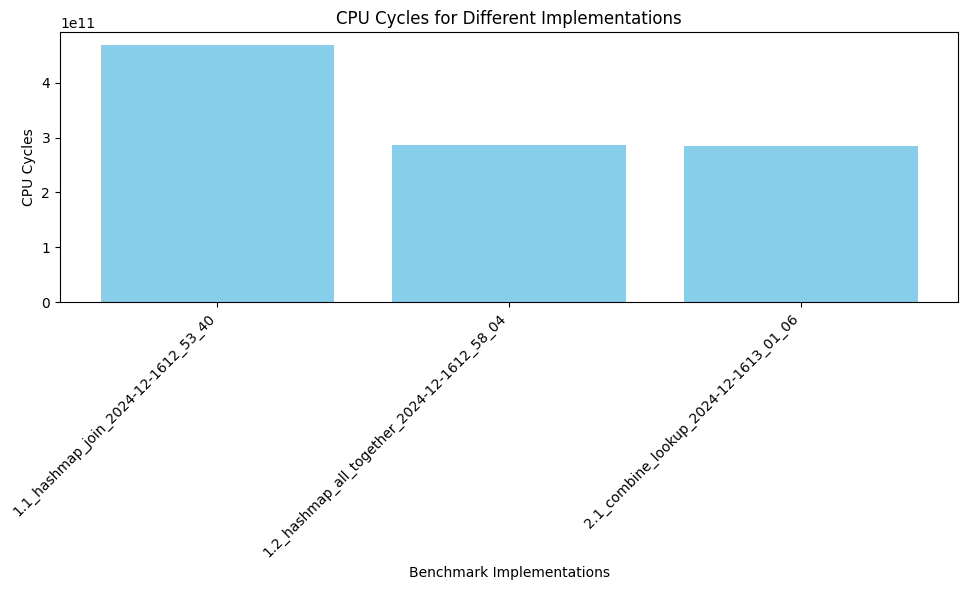

In [6]:
# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.bar(df['key'], df['cpu-cycles'], color='skyblue')
plt.xlabel('Benchmark Implementations')
plt.ylabel('CPU Cycles')
plt.title('CPU Cycles for Different Implementations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

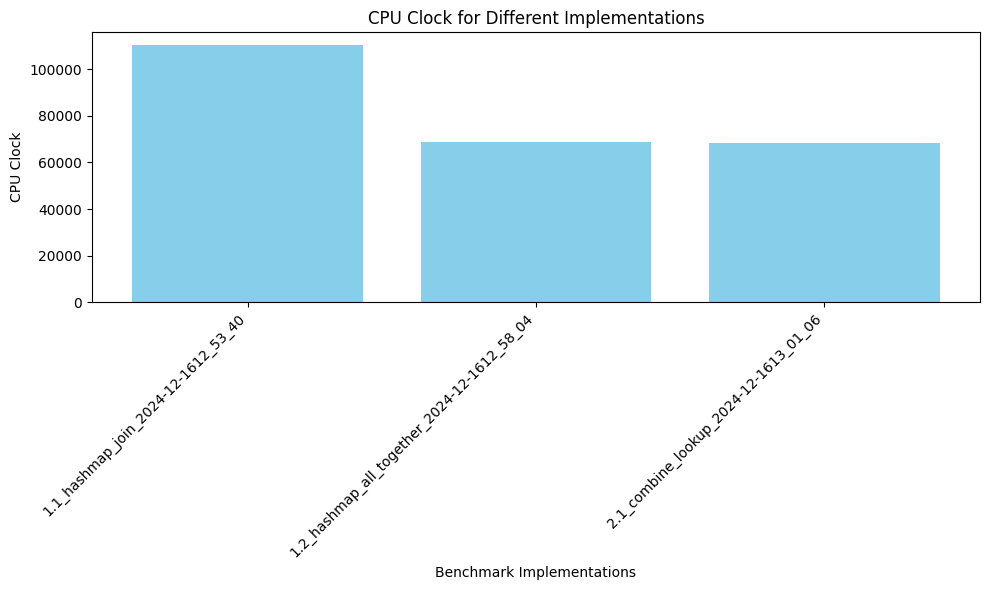

In [7]:
# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.bar(df['key'], df['cpu-clock'], color='skyblue')
plt.xlabel('Benchmark Implementations')
plt.ylabel('CPU Clock')
plt.title('CPU Clock for Different Implementations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()